# Exercise 1 Solution

#### Imports

In [1]:
import numpy as np
from numpy import sqrt, exp, sinh

# interactive plots
#%matplotlib notebook
# nice inline plots
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['text.usetex'] = True

#### Plotting Helpers
These are just to reduce repetition in the code below.

In [2]:
def common_plt(*, title, xlabel, ylabel, fontsize=14, xlim=None, ylim=None,
               xone=True, yone=True, legend=True, legend_loc=None):
    plt.gcf().set_size_inches(10, 7)
    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize, rotation='horizontal', ha='right')
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
    if xone:
        plt.axvline(1, color='grey', linestyle='--')
    if yone:
        plt.axhline(1, color='grey', linestyle='--')
    if legend:
        plt.legend(loc=legend_loc)
    plt.show()


def common_plt_potential(*args):
    plt.gcf().set_size_inches(6, 5)
    plt.ylim(0, 1.1)
    xs = np.linspace(-0.5, 5.5, num=100)
    for pot in args:
        try:
            plt.plot(xs, [pot(x) for x in xs])
        except TypeError:
            plt.plot(xs, [pot[0](x) for x in xs], pot[1])
    plt.show()

# Numerov's Method

#### Single Step

This implements
$\psi_{n+1}=
    \left(
        2\left( 1-\frac{5(\Delta x)^2}{12}k_n \right) \psi_n
        -\left( 1+\frac{(\Delta x)^2}{12}k_{n-1} \right) \psi_{n-1})
    \right) / \left(
        1+\frac{(\Delta x)^2}{12}k_{n+1}
    \right)$

In [3]:
def numerov_step(k0, k1, k2, psi0, psi1, dx):
    """Perform a single Numerov step to compute psi2."""
    dd = dx**2 / 12.
    c0 = (1 + dd * k0)
    c1 = 2 * (1 - 5 * dd * k1)
    c2 = (1 + dd * k2)
    #assert not np.isclose(c2, 0.) # slow!
    return (c1 * psi1 - c0 * psi0) / c2

As a basic test, let's check the "symmetry property" of a single Numerov step:

In [4]:
k = [5,7,6]
psi = [2,4]
psi.append(numerov_step(*k, *psi, 0.25))
assert np.isclose(
    numerov_step(*reversed(k), psi[2], psi[1], 0.25),
    psi[0]
)

#### High-Level Numerov

Here we wrap the Numerov step and chose between left-to-right and right-to-left evolution.

In [5]:
def numerov(k, psi0, psi1, x_min, x_max, n, right_to_left=False):
    """
    Compute psi = [psi0, psi1, ...] for k = k(x) via iterated Numerov
    steps according to the given discretization parameters.
    """
    dx = (x_max-x_min)/(n-1)  # np.linspace with retstep is slow
    if right_to_left:
        dx = -dx
        x_start = x_max
    else:
        x_start = x_min
    k0, k1 = k(x_start), k(x_start + dx)
    psi = np.zeros(n, dtype=np.complex128)
    psi[:2] = psi0, psi1

    for i in range(2, n):
        k2 = k(x_start + i * dx)
        psi[i] = numerov_step(k0, k1, k2, psi[i-2], psi[i-1], dx)
        k0, k1 = k1, k2

    if right_to_left:
        psi = psi[::-1]
    return psi

Visual check for a free particle.

In [6]:
E = 1
x_min, x_max = 0, 6
n = 50
xs, dx = np.linspace(x_min, x_max, num=n, retstep=True)
psi0, psi1 = 1, exp(1j * sqrt(2.*E) * dx)
k = lambda _: 2 * (E - 0)

psi = numerov(k, psi0, psi1, x_min, x_max, n)
psi_normed = np.abs(psi)**2 / np.abs(psi[0])**2
plt.plot(xs, psi_normed, '--', label='left to right')

psi = numerov(k, psi0, psi1, x_min, x_max, n, right_to_left=True)
psi_normed = np.abs(psi)**2 / np.abs(psi[-1])**2
plt.plot(xs, psi_normed, 'x', label='right to left')

common_plt(title='Visualising $|\Psi|^2$ for a free particle',
           xlabel='$x$', ylabel='$|\psi|^2$',
           xlim=[-1, 7], ylim=[0, 1.6], xone=False, yone=False)

Remember: the Numerov algorithm gives us the solution of a differential equation for specific starting points (and $k$).

# Problem 1.1 Scattering

Obtain $T,R$ by solving for $A,B$ (with $C=1$) in matched $x$ of  
$\psi_L=A\exp(iqx)+B\exp(-iqx)$ , $\psi_R=C\exp(iqx)$ .

In [7]:
def scatter(V, E, x_min, x_max, n, return_xs_psi=False, method='linsolve'):
    """
    Compute transmission & reflection coefficients for given 
    potential and energy (with m = hbar = 1).
    We assume that x_min and x_max correspond to the regime
    changing points (free particle <-> potential), but return
    one more xs,psi each before and after.
    """
    # compute step size for n+2 steps
    dx = (x_max - x_min) / (n+1)

    # start with right-travling wave at energy E
    # (with phase fixed to 1 at x_max)
    q_free = sqrt(2. * E)
    psi_2nd_last = exp(1j * q_free * x_max)
    psi_last     = exp(1j * q_free * (x_max+dx))

    # compute solution using Numerov
    k = lambda x: 2 * (E - V(x))
    psi = numerov(k, psi_last, psi_2nd_last,
                  x_min - dx, x_max + dx, n + 2, right_to_left=True)

    # A*exp(iq(xmin-dx)) + B*exp(-iq(xmin-dx)) = psi[0]
    # A*exp(iq(xmin   )) + B*exp(-iq(xmin   )) = psi[1]
    # this is less exact than dPsi/dx at x=xmin, but good enough
    if method == 'linsolve':
        A, B = np.linalg.solve(
            [
                [exp(1j * q_free * (x_min-dx)), exp(-1j * q_free * (x_min-dx))],
                [exp(1j * q_free * (x_min   )), exp(-1j * q_free * (x_min   ))]
            ],
            [psi[0], psi[1]]
        )
    # As an alternative method, we can use finite differences to get 
    # dpsi(x=0) = 1j * q * A - 1j * q * B
    elif method == 'dpsi':
        A = 0.5 * (psi[0] + (psi[1] - psi[0]) / (1j * q_free * dx))
        B = 0.5 * (psi[0] - (psi[1] - psi[0]) / (1j * q_free * dx))
    else:
        raise ValueError('Unknown method {}.'.format(method))
    # extract transmission and reflection coefficients
    T = 1 / abs(A)**2
    R = abs(B)**2 / abs(A)**2
    if return_xs_psi:
        xs = np.linspace(x_min-dx, x_max+dx, num=n+2)
        return (T, R, xs, psi)
    else:
        return (T, R)

Test: a free particle should be fully transmitted.

In [8]:
assert np.allclose(
    scatter(V=lambda _: 0, E=1, x_min=0, x_max=1, n=int(1e5)), [1, 0]
)

## 1. Rectangular Potential

In [9]:
def rect_potential(a):
    def V(x):
        return float(0 < x <= a)
    return V
common_plt_potential(rect_potential(a=5))

#### Wave Function

It is interesting to plot the wave function within the barrier, which already lets us observe quantum tunneling.  
Note: we are looking at probability density, don't scale to energy!

In [10]:
E = 0.9
plt.axvline(0, ls='--', color='grey')
X_MIN = 0
for a, color in zip([1, 2, 3, 5], ['red', 'blue', 'green', 'orange']):
    V = rect_potential(a=a)
    T, R, xs, psi = scatter(V=V, E=E, x_min=X_MIN, x_max=a, n=1000,
                            return_xs_psi=True)
    psi_sqn = np.abs(psi)**2 * T
    plt.plot(xs, psi_sqn, color=color, label='a = {}'.format(a))
    plt.axvline(a, ls='--', color=color)

common_plt(title='Norm square of $\psi$ within the barrier',
           xlabel='$x$', ylabel='$|\psi|^2$',
           xlim=[X_MIN - 1, a + 1], ylim=[0, max(psi_sqn) + 0.2], xone=False, yone=True, legend=None)

#### Analytical expression for the transmission probability
From exercise 1 task sheet.

In [11]:
def transmission_exact(a, E):
    assert not np.isclose(E, 1.)
    kappa = sqrt(2 * (1 - E) + 0j)
    return 1. / (1 + sinh(kappa * a)**2 / (4. * E * (1 - E))).real

#### Convergence to the Analytical Value

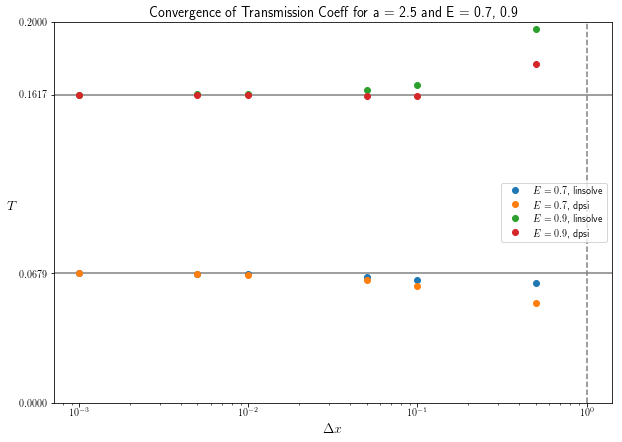

In [12]:
a = 2.5
V = rect_potential(a=a)
Es = [0.7, 0.9]
Ts_exact = [transmission_exact(a=a, E=E) for E in Es]
step_sizes = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

for E, T_exact in zip(Es, Ts_exact):
    # show theoretical value as horizontal line
    plt.axhline(T_exact, color='gray')

    # plot numerical data points
    Ts_linsolve = [
        scatter(V=V, E=E, x_min=0, x_max=a, n=int(np.ceil(a / dx)), method='linsolve')[0]
        for dx in step_sizes
    ]
    Ts_dpsi = [
        scatter(V=V, E=E, x_min=0, x_max=a, n=int(np.ceil(a / dx)), method='dpsi')[0]
        for dx in step_sizes
    ]
    plt.semilogx(step_sizes, Ts_linsolve, 'o', label='$E={}$, linsolve'.format(E))
    plt.semilogx(step_sizes, Ts_dpsi, 'o', label='$E={}$, dpsi'.format(E))

plt.yticks([0, *Ts_exact, 0.2])
common_plt(title='Convergence of Transmission Coeff for a = {} and E = {}'.format(
        a, ', '.join(str(E) for E in Es)
    ),
    xlabel='$\Delta x$',
    ylabel='$T$',
    ylim=[0, 0.2],
    legend_loc='center right')

This tells us that want $\Delta x<=0.01$.

The ``'linsolve'`` method seems to generally calculate higher T, which is benefitia

#### Dependence on Energy

In [13]:
as_ = np.linspace(0.5, 5, 4)
colors = cm.rainbow(1 - as_ / 5)
Es = np.linspace(.01, 3.99, 1000)
Es_coarse = np.arange(.01, 4., .05)
# choose n such that dx ~ 0.01
n = int(as_[-1] / 0.01)

for a, color in zip(as_, colors):
    # plot theoretical value
    plt.plot(Es, [transmission_exact(a=a, E=E) for E in Es], color=color,
             label='a = {:.2f}'.format(a))

    # plot numerical data points
    Ts_approx = [
        scatter(V=rect_potential(a), E=E, x_min=0, x_max=a, n=n)[0]
        for E in Es_coarse
    ]
    l = plt.plot(Es_coarse, Ts_approx, 'o', color=color)

common_plt(
    title='Transmission Coeff as a Function of Energy',
    xlabel='$E$', ylabel='$T$',
    xlim=[0, Es_coarse[-1]], ylim=[0, 1.1],
    legend_loc='lower right'
)

Note that $E>1$ is above the potential.

#### Dependence on Barrier Width

In [14]:
E = .96
as_ = np.linspace(.01, 5)
as_coarse = np.linspace(0.5, 5, 10)
n = int(as_[-1] / 0.01)

plt.plot(as_, [transmission_exact(a=a, E=E) for a in as_], label='exact')
plt.plot(
    as_coarse,
    [
        scatter(V=rect_potential(a=a), E=E, x_min=0, x_max=a, n=n)[0]
        for a in as_coarse
    ],
    'o', label='numeric'
)

common_plt(
    title='Transmission Coeff as a Function of the Barrier width '
          'for Fixed Energy $E = {}$'.format(E),
    xlabel='$a$', ylabel='$T$',
    xlim=[0, as_[-1]], ylim=[0, 1.1],
    xone=False,
    legend_loc='center right'
)

## 2. Parabolic Potential

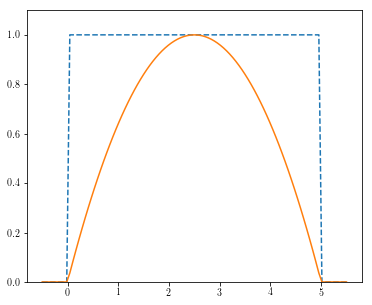

In [15]:
def parabolic_potential(a):
    a = float(a)

    def V(x):
        if 0 < x <= a:
            return 4. * (x / a - x**2 / a**2)
        return 0.
    return V

common_plt_potential([rect_potential(a=5), '--'],
                     parabolic_potential(a=5))

#### Compare Dependence on Energy

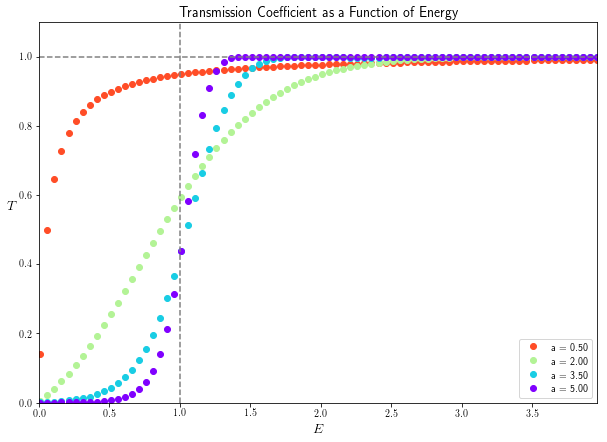

In [16]:
as_ = np.linspace(0.5, 5, 4)
colors = cm.rainbow(1 - as_ / 5)
Es_coarse = np.arange(.01, 4, .05)
n = int(as_[-1] / 0.01)

for a, color in zip(as_, colors):
    # plot numerical data points
    Ts_parabolic = [
        scatter(V=parabolic_potential(a), E=E, x_min=0, x_max=a, n=n)[0]
        for E in Es_coarse
    ]
    l = plt.plot(Es_coarse, Ts_parabolic, 'o', color=color,
                 label='a = {:.2f}'.format(a))

common_plt(
    title='Transmission Coefficient as a Function of Energy',
    xlabel='$E$', ylabel='$T$',
    xlim=[0, Es_coarse[-1]], ylim=[0, 1.1],
    legend_loc='lower right'
)

This can be used for approximation of the tunneling current $I\propto T(a)$ in Scanning Tunnelling Microscopy (STM).

#### Compare Dependence on Barrier Width

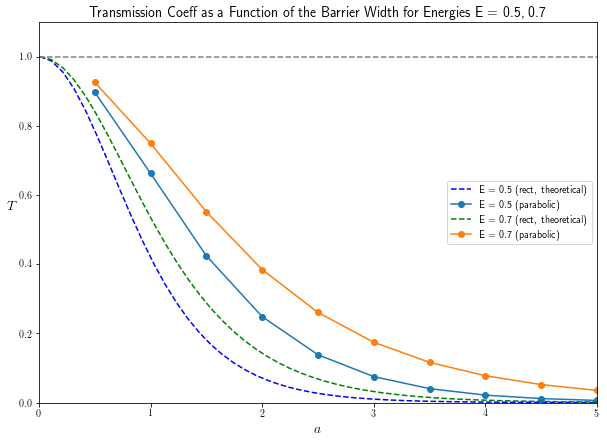

In [17]:
Es = [.5, .7]
colors = ['blue', 'green']
as_ = np.linspace(.01, 5)
as_coarse = np.linspace(0.5, 5, 10)
n = int(as_[-1] / 0.01)

for E, color in zip(Es, colors):
    # plot theoretical value
    plt.plot(as_, [transmission_exact(a=a, E=E) for a in as_], '--',
             color=color, label='E = {} (rect, theoretical)'.format(E))

    # plot numerical data points
    plt.plot(as_coarse,
             [
                 scatter(V=parabolic_potential(a=a), E=E,
                         x_min=0, x_max=a, n=n)[0]
                 for a in as_coarse
             ],
             'o-', label='E = {} (parabolic)'.format(E))

common_plt(
    title='Transmission Coeff as a Function of the Barrier Width '
          'for Energies E = ' + ', '.join(str(E) for E in Es),
    xlabel='$a$', ylabel='$T$',
    xlim=[0, as_[-1]], ylim=[0, 1.1],
    xone=False,
    legend_loc='center right'
)

The numerics confirm our intuition that the parabolic potential transmits "better" than the (analytically solvable) rectangular potential: there is less material to tunnel through.

## 3. Fourth Order Potential

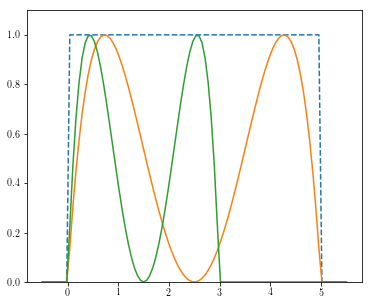

In [18]:
def bound_potential(a):
    a = float(a)

    def V(x):
        if 0 < x <= a:
            return 4 * (((x - a / 2) / (a / 2))**2 - ((x - a / 2) / (a / 2))**4)
        return 0.
    return V

common_plt_potential([rect_potential(a=5), '--'],
                     bound_potential(a=5),
                     bound_potential(a=3))

#### Compare Dependence on Energy

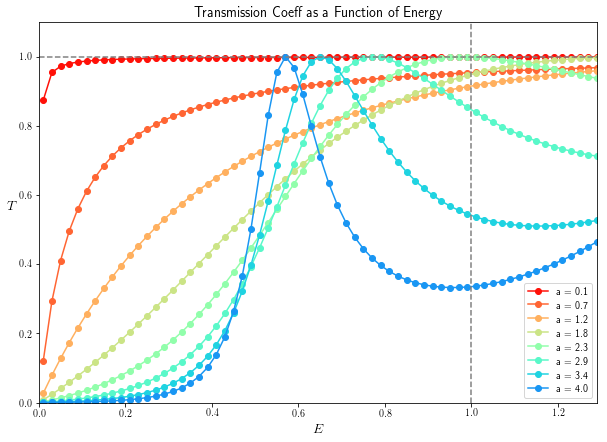

In [19]:
as_ = np.linspace(0.1, 4, 8)
colors = cm.rainbow(1 - as_ / 5)
Es_coarse = np.arange(.01, 1.3, .02)
n = int(as_[-1] / 0.01)

for a, color in zip(as_, colors):
    # plot numerical data points
    Ts_parabolic = [
        scatter(V=bound_potential(a), E=E, x_min=0, x_max=a, n=n)[0]
        for E in Es_coarse
    ]
    l = plt.plot(Es_coarse, Ts_parabolic, 'o-', color=color,
                 label='a = {:.1f}'.format(a))

common_plt(
    title='Transmission Coeff as a Function of Energy',
    xlabel='$E$', ylabel='$T$',
    xlim=[0, Es_coarse[-1]], ylim=[0, 1.1],
    legend_loc='lower right'
)

Note how the peak transmission reaches 100% for certain energies below 1.  
Explanation: destructive interference and energy conservation (Fabry-Pérot interferometer).

#### Compare with Harmonic Oscillator

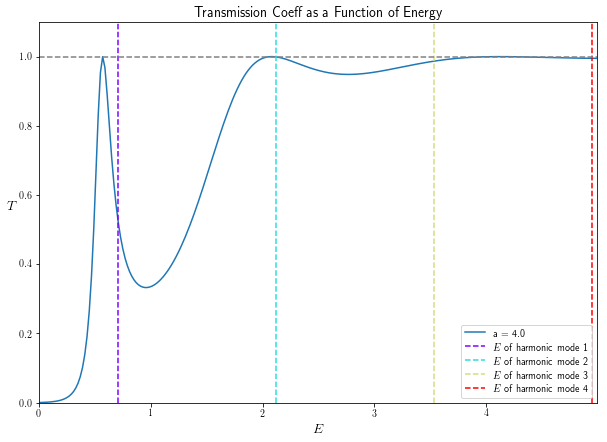

In [20]:
Es_coarse = np.arange(.01, 5.0, .02)
a = 4.0
n = int(a / 0.01)

# plot numerical data points
Ts_parabolic = [
    scatter(V=bound_potential(a), E=E, x_min=0, x_max=a, n=n)[0]
    for E in Es_coarse
]
plt.plot(Es_coarse, Ts_parabolic, '-', label='a = {:.1f}'.format(a))

harm_n = 4
colors = iter(cm.rainbow(np.linspace(0, 1, harm_n)))
E_harm = lambda n: sqrt(2) * 4 / a * (n + 0.5)
for n in range(harm_n):
    plt.axvline(E_harm(n), linestyle='--', color=next(colors),
                label="$E$ of harmonic mode {}".format(n + 1))

common_plt(
    title='Transmission Coeff as a Function of Energy',
    xlabel='$E$', ylabel='$T$',
    xlim=[0, Es_coarse[-1]], ylim=[0, 1.1],
    xone=False,
    legend_loc='lower right'
)

Comparison with the energy levels for the harmonic oscillator.

#### Plot wave function

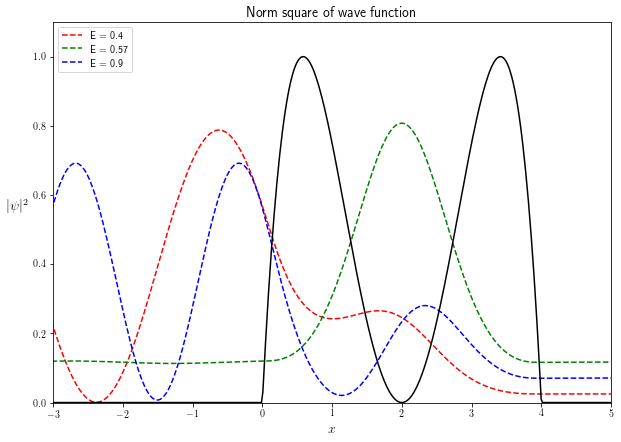

In [21]:
a = 4.0
n = int(a / 0.01)

V = bound_potential(a)
for E, color in zip([0.4, 0.57, 0.9], ['r', 'g', 'b']):
    T, _, xs, psi = scatter(
        V=V, E=E, x_min=-3, x_max=a+1, n=n, return_xs_psi=True
    )
    norm = np.sum(np.abs(psi)**2) * a / n
    plt.plot(xs, np.abs(psi)**2 / norm, '--',
             color=color, label='E = {}'.format(E))
plt.plot(xs, [V(x) for x in xs], color='k')

common_plt(
    title='Norm square of wave function',
    xlabel='$x$', ylabel='$|\psi|^2$',
    xlim=[-3, a+1], ylim=[0, 1.1],
    xone=False,
    yone=False,
    legend_loc='upper left'
)

Note how the $E=0.9$ wavefunction has a lower amplitude than the $E=0.4$ wavefunction. This is due to destructive interference for this specific width of the barrier.

# Playground

In [22]:
scatter(rect_potential(a=1), E=0.6343971, x_min=0, x_max=1, n=100000)

(0.49999947319036714, 0.5000005260908649)

In [23]:
def weird_pot(a):
    a = float(a)

    def V(x):
        if 0 < x <= a / 2:
            return 1 - x / a
        if a / 2 < x <= a:
            return 2 * x / a - 1
        return 0.
    return V

import ipywidgets as wgt


def iplot(a):
    xs = np.linspace(-0.5, 5.5, num=100)
    plt.plot(xs, [weird_pot(a=a)(x) for x in xs])
    common_plt_potential([rect_potential(a=5), '--'], weird_pot(a=5))

wgt.interact(iplot, a=(0.1, 5, 0.1));

interactive(children=(FloatSlider(value=2.5000000000000004, description='a', max=5.0, min=0.1), Output()), _dom_classes=('widget-interact',))

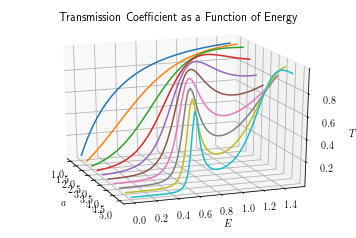

In [24]:
as_ = np.linspace(1, 5, 10)
colors = cm.rainbow(1 - as_ / 5)
Es_coarse = np.arange(.01, 1.5, .02)
#n = as_[-1]/0.01
n = 40

from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')
ax.view_init(elev=20., azim=-20)

for a, color in zip(as_, colors):
    # plot numerical data points
    Ts_parabolic = [
        scatter(V=weird_pot(a), E=E, x_min=0, x_max=a, n=n)[0]
        for E in Es_coarse
    ]
    ax.plot(np.full((len(Es_coarse)), a), Es_coarse, Ts_parabolic)

plt.title('Transmission Coefficient as a Function of Energy')
plt.xlabel('$a$')
plt.ylabel('$E$')
ax.set_zlabel('$T$')
plt.show()

In [25]:
a = 4.0
#n = a/0.01
n = 40

V = weird_pot(a)


def iplot(E):
    T, _, xs, psi = scatter(V=V, E=E, x_min=0, x_max=a,
                            n=n, return_xs_psi=True)
    plt.plot(xs, [V(x) for x in xs], color='k')
    norm = np.sum(np.abs(psi)**2) * a / n
    plt.plot(xs, np.abs(psi)**2 / norm, '--', color=color,
             label='E = {}'.format(E))
    common_plt(
        title='Norm square of wave function',
        xlabel='$x$', ylabel='$|\psi|^2$',
        xlim=[-0.5, a + 0.5], ylim=[0, 1.1],
        xone=False
    )

wgt.interact(iplot, E=(0.1, 0.9, 0.01));

interactive(children=(FloatSlider(value=0.5, description='E', max=0.9, min=0.1, step=0.01), Output()), _dom_classes=('widget-interact',))